In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('thesis')
from sklearn.metrics import mean_squared_error

## Defining functions

In [2]:
root = "sfh_500_10_20251201_091914"
real_spec = np.load(f"/data/mustard/vmehta/{root}/{root}_snr_spectra.npy")
real_sfh = np.vstack(10**(np.load(f"/data/mustard/vmehta/{root}/snr__all_true.npy")))
wav = np.load(f"/data/mustard/vmehta/{root}/{root}_wavelength.npy")

# Bin setup (used in multiple places)
bin_arr = np.r_[np.array([0.1, 20, 50, 100, 200, 500])*1e6, np.logspace(9.5, 10.15, 5)]
binning = np.log10(bin_arr)
bin_widths = np.diff(binning)
bin_centers = binning[:-1] + bin_widths/2

def load_noisy_data(snr, NoisyTraining=False):
    if NoisyTraining:
        pred_sfh = np.vstack(10**(np.load(f"/data/mustard/vmehta/{root}/noisy_training/snr_{snr}_all_pred.npy")))
    else:
        if snr == None:
            pred_sfh = np.vstack(10**(np.load(f"/data/mustard/vmehta/{root}/snr__all_pred.npy")))
        else:
            pred_sfh = np.vstack(10**(np.load(f"/data/mustard/vmehta/{root}/noiseless_training/snr_{snr}_all_pred.npy")))
    return pred_sfh

# noiseless predictions
snrNone = load_noisy_data(None)

def rmse(pred_sfh):
    rmse = np.sqrt(mean_squared_error(real_sfh, pred_sfh, multioutput='raw_values'))
    overall_rmse = np.sqrt(mean_squared_error(real_sfh, pred_sfh))
    return rmse, overall_rmse

def plot_sfh(snr, n):
    plt.figure(figsize=(10,5))
    plt.bar(bin_centers, real_sfh[n], width=bin_widths, alpha=0.5, label='True SFH', color='grey', edgecolor='black')
    plt.bar(bin_centers, snr[n], width=bin_widths, alpha=0.3, label='Predicted SFH', color='red', edgecolor='red')
    plt.bar(bin_centers, snrNone[n], width=bin_widths, alpha=0.3, label='Predicted SFH (No Noise)', color='blue', edgecolor='blue')
    plt.xlabel('Log Age (years)')
    plt.ylabel('f')
    plt.title(f'Star Formation History Comparison (n={n})')
    plt.legend()
    plt.show()

def plot_diff(snr):

    diff = snr - real_sfh
    nonoise_diff = snrNone - real_sfh

    median = np.median(diff, axis=0)
    sixteen = np.percentile(diff, 16, axis=0)
    eightyfour = np.percentile(diff, 84, axis=0)

    median_nonoise = np.median(nonoise_diff, axis=0)
    sixteen_nonoise = np.percentile(nonoise_diff, 16, axis=0)
    eightyfour_nonoise = np.percentile(nonoise_diff, 84, axis=0)

    plt.figure(figsize=(10,5))
    plt.errorbar(bin_centers, median, yerr=[median - sixteen, eightyfour - median], fmt='o', capsize=5, label=f'Noisy')
    plt.errorbar(bin_centers, median_nonoise, yerr=[median_nonoise - sixteen_nonoise, eightyfour_nonoise - median_nonoise], fmt='o', capsize=5, label='No Noise')
    plt.xlabel('log(Age)')
    plt.ylabel('Difference (pred - true)')
    plt.xlim(2.5,10.5)
    plt.legend()
    plt.show()

## When noisy data is tested on model trained with noiseless data

In [3]:
snr500 = load_noisy_data(500)
snr100 = load_noisy_data(100)
snr50 = load_noisy_data(50)
snr10 = load_noisy_data(10)

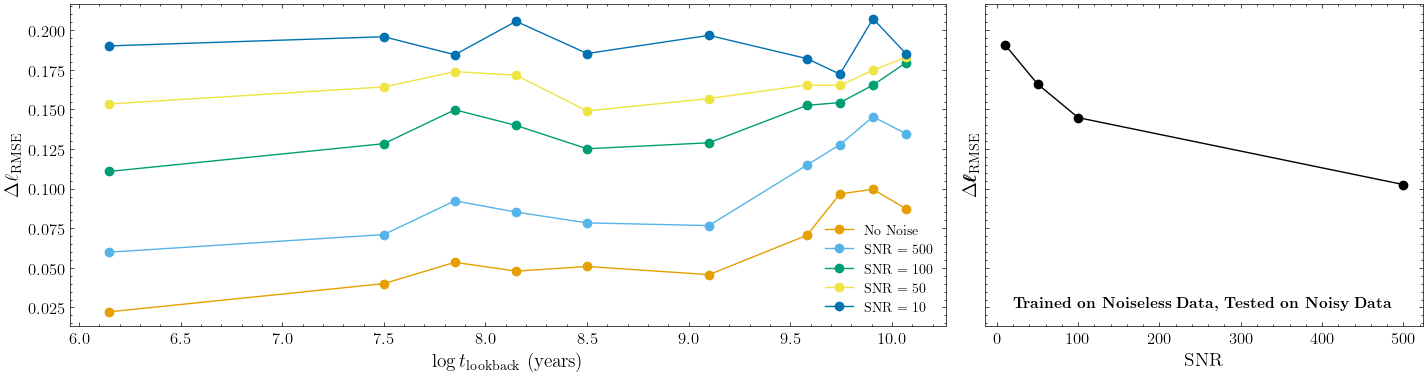

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

ax[0].plot(bin_centers, rmse(snrNone)[0], marker='o')
for s in [snr500, snr100, snr50, snr10]:
    ax[0].plot(bin_centers, rmse(s)[0], marker='o')
ax[0].set_xlabel('$\\log t_\\mathrm{lookback}$ (years)')
ax[0].set_ylabel('$\\Delta\\ell_\\mathrm{RMSE}$')
ax[0].legend(labels=['No Noise', 'SNR = 500', 'SNR = 100', 'SNR = 50', 'SNR = 10'], fontsize=10)

ax[1].plot(np.array([500, 100, 50, 10]), [rmse(snr500)[1], rmse(snr100)[1], rmse(snr50)[1], rmse(snr10)[1]], 'ko-')
ax[1].set_xlabel('SNR')
ax[1].set_ylabel('$\\Delta\\pmb\\ell_\\mathrm{RMSE}$')
ax[1].text(20, 0.025, "\\textbf{Trained on Noiseless Data, Tested on Noisy Data}")
plt.tight_layout()
plt.show()

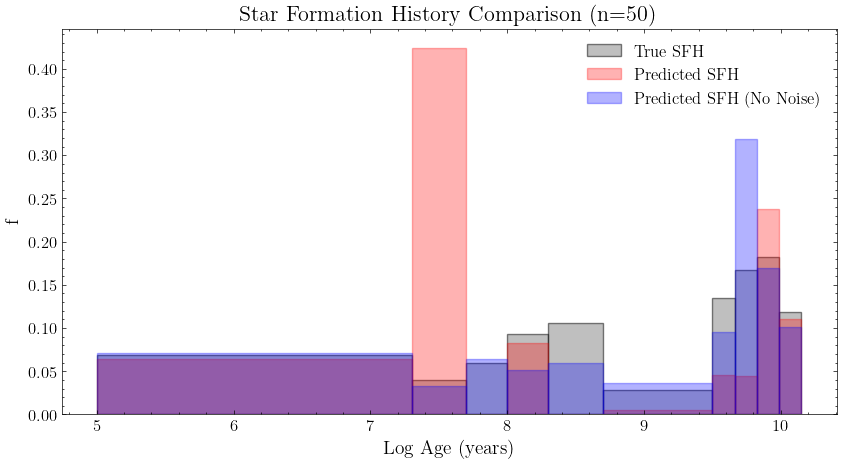

In [5]:
plot_sfh(snr100, 50)

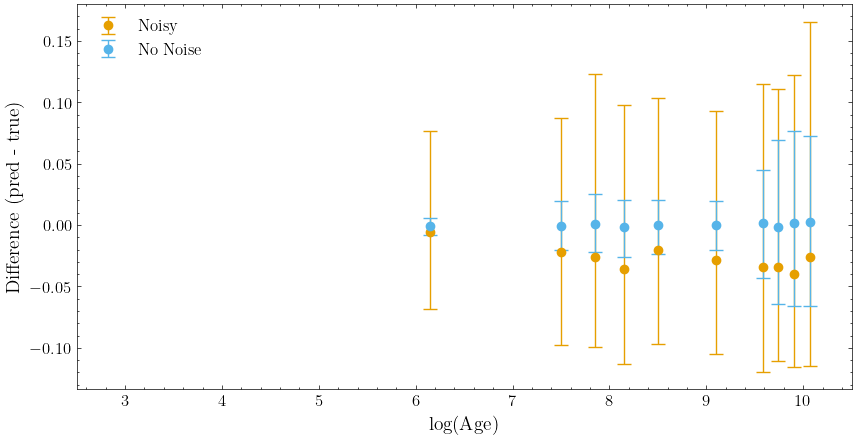

In [6]:
plot_diff(snr100)

## When noisy data is tested on model trained with noisy data

In [7]:
snr500_n = load_noisy_data(500, NoisyTraining=True)
snr100_n = load_noisy_data(100, NoisyTraining=True)
snr50_n = load_noisy_data(50, NoisyTraining=True)
snr10_n = load_noisy_data(10, NoisyTraining=True)

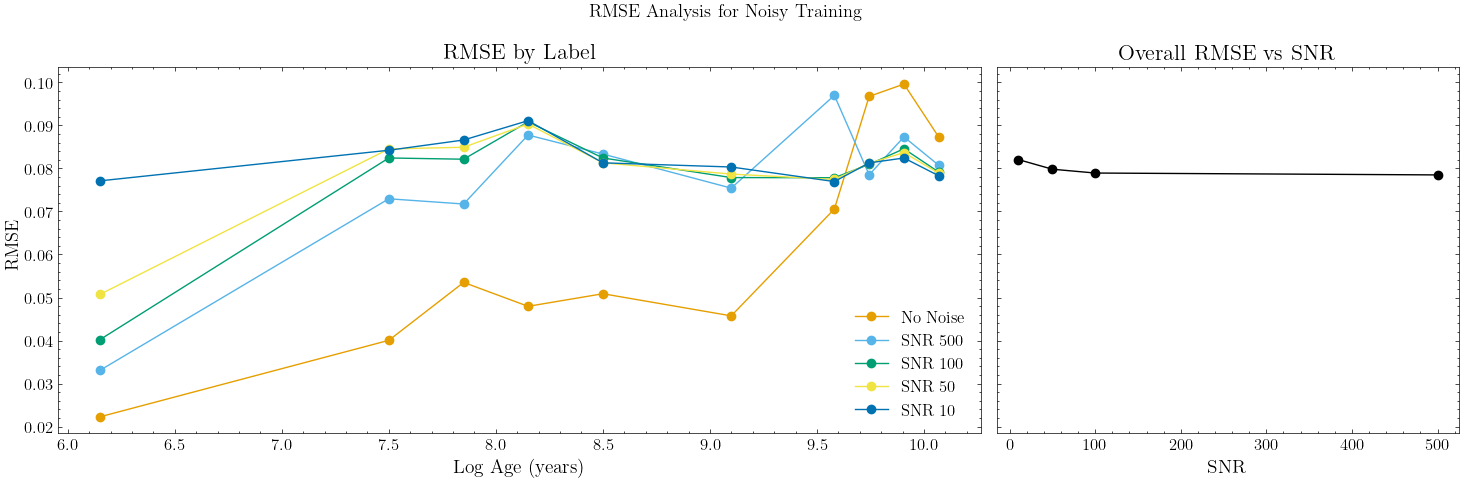

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [2, 1]})

ax[0].plot(bin_centers, rmse(snrNone)[0], marker='o')
for s in [snr500_n, snr100_n, snr50_n, snr10_n]:
    ax[0].plot(bin_centers, rmse(s)[0], marker='o')
ax[0].set_xlabel('Log Age (years)')
ax[0].set_title('RMSE by Label')
ax[0].legend(labels=['No Noise', 'SNR 500', 'SNR 100', 'SNR 50', 'SNR 10'])

ax[1].plot(np.array([500, 100, 50, 10]), [rmse(snr500_n)[1], rmse(snr100_n)[1], rmse(snr50_n)[1], rmse(snr10_n)[1]], 'ko-')
ax[1].set_title('Overall RMSE vs SNR')
ax[1].set_xlabel('SNR')

fig.supylabel('RMSE')
fig.suptitle('RMSE Analysis for Noisy Training')
plt.tight_layout()

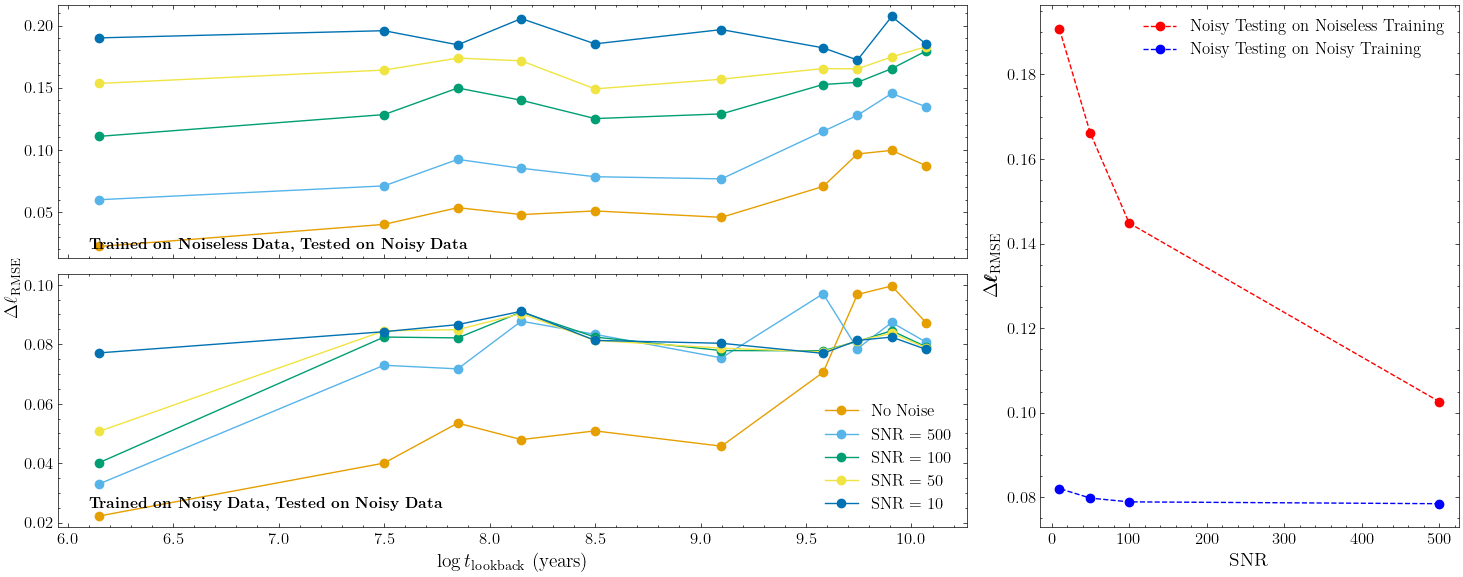

In [28]:
fig = plt.figure(figsize=(15,6))

ax1 = plt.subplot2grid((2,3), (0,0), colspan=2)
ax2 = plt.subplot2grid((2,3), (1,0), colspan=2)
ax3 = plt.subplot2grid((2,3), (0,2), rowspan=2)

ax1.plot(bin_centers, rmse(snrNone)[0], marker='o')
ax2.plot(bin_centers, rmse(snrNone)[0], marker='o')

for s in [snr500, snr100, snr50, snr10]:
    ax1.plot(bin_centers, rmse(s)[0], marker='o')
ax1.set_xticklabels([])
ax1.text(6.1, 0.02, "\\textbf{Trained on Noiseless Data, Tested on Noisy Data}")

for s in [snr500_n, snr100_n, snr50_n, snr10_n]:
    ax2.plot(bin_centers, rmse(s)[0], marker='o')
ax2.legend(labels=['No Noise', 'SNR = 500', 'SNR = 100', 'SNR = 50', 'SNR = 10'])
ax2.text(6.1, 0.025, "\\textbf{Trained on Noisy Data, Tested on Noisy Data}")
ax2.set_xlabel('$\\log t_\\mathrm{lookback}$ (years)')

ax3.plot(np.array([500, 100, 50, 10]), [rmse(snr500)[1], rmse(snr100)[1], rmse(snr50)[1], rmse(snr10)[1]], 'ro--', label='Noisy Testing on Noiseless Training')
ax3.plot(np.array([500, 100, 50, 10]), [rmse(snr500_n)[1], rmse(snr100_n)[1], rmse(snr50_n)[1], rmse(snr10_n)[1]], 'bo--', label='Noisy Testing on Noisy Training')
ax3.legend()
ax3.set_xlabel('SNR')
ax3.set_ylabel('$\\Delta\\pmb\\ell_\\mathrm{RMSE}$')

fig.supylabel('$\\Delta\\ell_\\mathrm{RMSE}$')
plt.tight_layout()
plt.show()

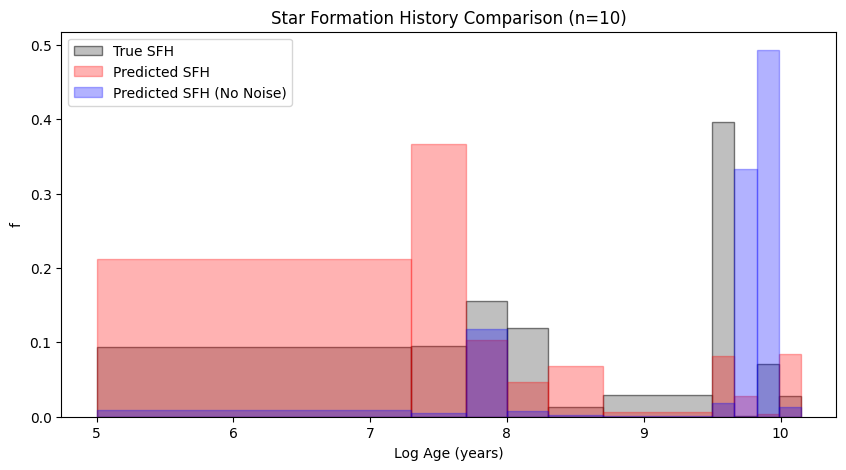

In [ ]:
plot_sfh(snr100_n, 10)

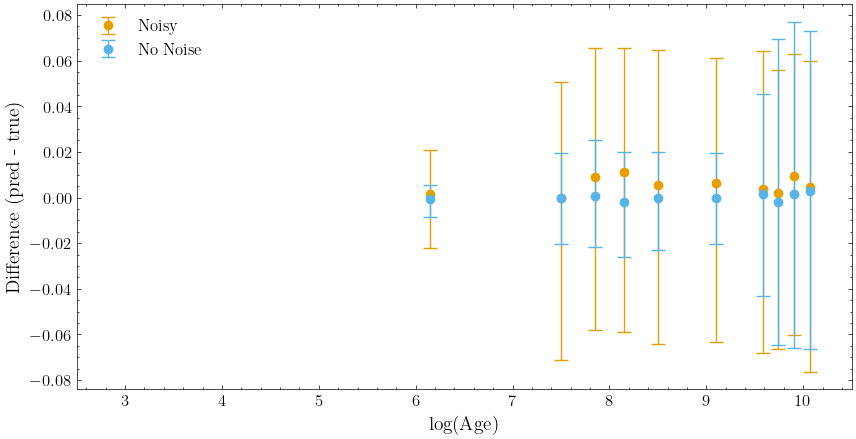

In [11]:
plot_diff(snr100_n)

## Side-by-side comparisons of two approaches

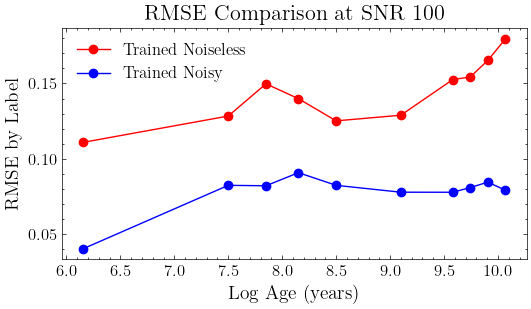

Overall RMSE (Trained Noiseless): 0.14482822485771055
Overall RMSE (Trained Noisy): 0.07891813117730165


In [9]:
plt.figure(figsize=(6,3))
plt.plot(bin_centers, rmse(snr100)[0], 'ro-', label='Trained Noiseless')
plt.plot(bin_centers, rmse(snr100_n)[0], 'bo-', label='Trained Noisy')
plt.xlabel('Log Age (years)')
plt.ylabel('RMSE by Label')
plt.title('RMSE Comparison at SNR 100')
plt.legend()
plt.show()

print("Overall RMSE (Trained Noiseless):", rmse(snr100)[1])
print("Overall RMSE (Trained Noisy):", rmse(snr100_n)[1])